In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime as dt
import urllib.request, json
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


#https://www.youtube.com/watch?v=zwqwlR48ztQ&feature=youtu.be

In [18]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'WBORNSCHXG23ZIZU'

    # Put desired ticker symbol. For example, FB for Facebook
    ticker = "FB"

    # JSON file with all the stock market data for the ticker symbol inputted above
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # Store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

File already exists. Loading data from CSV


In [19]:
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
0,1806,2019-07-25,198.5800,208.650,199.3938,206.70
1,1805,2019-07-24,197.2200,204.810,204.6600,197.63
2,1804,2019-07-23,200.9625,204.242,202.3600,202.84
3,1803,2019-07-22,198.8100,202.570,202.3200,199.91
4,1802,2019-07-19,198.0700,202.330,198.3600,202.18


In [20]:
'Date','Open','High','Low','Close'

dataset_train = df.drop(['Unnamed: 0'], axis=1)
training_set = dataset_train.iloc[:,3:4].values

dataset_train.head()

,Date,Low,High,Close,Open
0,2019-07-25,198.5800,208.650,199.3938,206.70
1,2019-07-24,197.2200,204.810,204.6600,197.63
2,2019-07-23,200.9625,204.242,202.3600,202.84
3,2019-07-22,198.8100,202.570,202.3200,199.91
4,2019-07-19,198.0700,202.330,198.3600,202.18


In [21]:
#training_data.info()

In [22]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [23]:
training_set_scaled

array([[0.90936522],
       [0.93572641],
       [0.92421322],
       ...,
       [0.06643106],
       [0.08159843],
       [0.10263151]])

In [24]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
#X_train

# Part 2 - Building the RNN

In [27]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [32]:
#Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
1747/1747 [==============================] - 14s 8ms/step - loss: 0.0305: 1s - loss: 0
Epoch 2/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0037
Epoch 3/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0031
Epoch 4/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0036
Epoch 5/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0033
Epoch 6/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0027
Epoch 7/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0031
Epoch 8/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0025
Epoch 9/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0029
Epoch 10/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0031
Epoch 11/20
1747/1747 [==============================] - 8s 5ms/step - loss: 0.0027
Epoch 12/20
1747/1747 [==============================] - 8s 5ms/step -

# Part 3 - Making the predictions and visualising the results

In [33]:
# Getting the real stock price
dataset_test = dataset_train
real_stock_price = dataset_test.iloc[:, 3:4].values

In [34]:
# Getting the predicted stock price
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [37]:
real_stock_price

array([[199.3938],
       [204.66  ],
       [202.36  ],
       ...,
       [ 31.    ],
       [ 34.03  ],
       [ 38.2318]])

In [38]:
predicted_stock_price

array([[29.491076],
       [30.688318],
       [33.73578 ],
       ...,
       [20.671486],
       [20.66759 ],
       [20.687225]], dtype=float32)

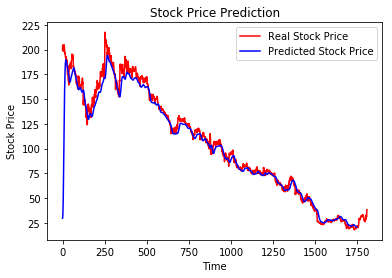

In [35]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()